# Data extraction

Send request for BTC pricing data and store response locally.

In [4]:
import requests

response = requests.get("https://www.satochi.co/allBTCPrice")

with open("btc_raw.txt","wb") as file:
    file.write(response.content)

Send request for VT and IGLO pricing data and store responses locally

In [26]:
import requests

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest"
}

payload = {
    "header": "%s Historical Data",
    "st_date": "19/08/2008",
    "end_date": "19/09/2021",
    "interval_sec": "Daily",
    "sort_col": "date",
    "sort_ord": "DESC",
    "action": "historical_data"
}

url = "https://uk.investing.com/instruments/HistoricalDataAjax"

etfs = [
    {
        "header":"iglo", 
        "curr_id": 45629,
        "smlID": 2530788,
    },
    {
        "header":"vt", 
        "curr_id": 38224,
        "smlID": 2505638,
    }
]

for etf in etfs:
    payload_etf = payload.copy()
    payload_etf["header"] = payload_etf["header"] % etf["header"].upper()
    payload_etf["curr_id"] = etf["curr_id"]
    payload_etf["smlID"] = etf["smlID"]

    response = requests.post(url, data=payload_etf, headers=headers)

    with open(etf["header"]+"_raw.txt", "wb") as file:
        file.write(response.content)

# Data preparation

Convert BTC response data into DataFrame

In [2]:
import pandas as pd

with open("btc_raw.txt", "rb") as file:
    btc = pd.read_json(file)
    
btc.columns = ["date","btc"]
btc["date"] = pd.to_datetime(btc["date"])
btc = btc.set_index("date")

Convert ETF responses into DataFrames

In [3]:
def csv_read(etf):
    df = pd.read_csv(etf+"_raw.csv")
    df = df.loc[:,["Date"," Close"]]
    df.columns = ["date", etf]
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    
    return df

vt = csv_read("vt")
bnd = csv_read("bnd")
igov = csv_read("igov")

In [54]:
bonds = bnd.copy()

In [4]:
bonds = pd.concat([bnd,igov], axis=1)

bonds["bonds"] = (bonds["bnd"] + bonds["igov"]) / 2

bonds = bonds.drop(["bnd","igov"], axis=1)

bonds = bonds.dropna()

Combine all dataframes into a single one.

NOTE: the Bitcoin DataFrame covers all days in the time series.

In [56]:
combined_df = pd.concat([btc,vt,bonds], axis=1)

columns = ["btc","equities","bonds"]
combined_df.columns = columns

Take out first rows until all are not `NaN`

In [57]:
df_start = combined_df[
    (combined_df["btc"]>0) & (combined_df["bonds"]>0) 
    & (combined_df["equities"]>0)].index[0]

combined_df = combined_df.loc[df_start:]

Fill `NaN` values

In [58]:
combined_df = combined_df.fillna(method="ffill")

Create DataFrame of rolling log returns

In [59]:
import numpy as np

log_df = combined_df.copy()

for col in columns:
    log_df[col+"-log"] = np.log(log_df[col])
    
def my_fun(x):
    return x.iloc[-1] - x.iloc[0]

corr_df = log_df.rolling(window=356).apply(my_fun).iloc[356:,3:]
corr_df.columns = ["Bitcoin", "Equities", "Bonds"]

# Correlation matrix chart

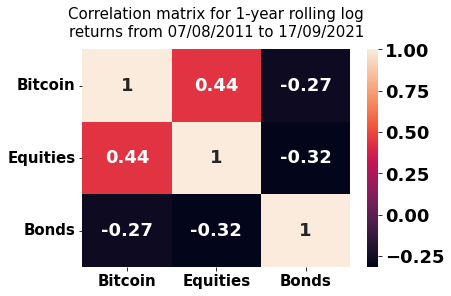

In [60]:
import matplotlib.pyplot as plt
import seaborn as sn

corr = corr_df.corr()

params = {
    "axes.facecolor":"white",
    "figure.facecolor":"white",
    "font.size": 18,
    "font.weight": 1000,
    "axes.titlepad": 13,
}

plt.rcParams.update(params)

start_date = corr_df.index[0].strftime("%d/%m/%Y")
end_date = corr_df.index[-1].strftime("%d/%m/%Y")

title = "Correlation matrix for 1-year rolling log\nreturns from {} to {}".format(start_date,end_date)

res = sn.heatmap(corr, annot=True)

res.set_title(title,fontsize=15)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 15)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 15)

plt.yticks(rotation=0)

plt.savefig("btc-corr.png",bbox_inches='tight')

plt.show()
plt.close()

# Correlation changes over time

Split the combined dataframe by year

In [10]:
corr_copy = corr_df.copy()

corr_copy['year'] = corr_copy.index.year

years = corr_copy["year"].unique()

split_df = [{"year":y,"df":corr_copy[corr_copy['year'] == y]} for y in years]

Create dataframe for correlation matrices timeseries

In [11]:
hist = pd.DataFrame(data=[[x["year"],
 x["df"]["Bitcoin"].corr(x["df"]["Equities"]),
 x["df"]["Bitcoin"].corr(x["df"]["Bonds"]),
 x["df"]["Bonds"].corr(x["df"]["Equities"])]
 for x in split_df],
             columns=["Year","Bitcoin / Equities","Bitcoin / Bonds","Equities / Bonds"])

hist.iloc[:,1:] = hist.iloc[:,1:]
hist = hist.set_index("Year")

Generate chart

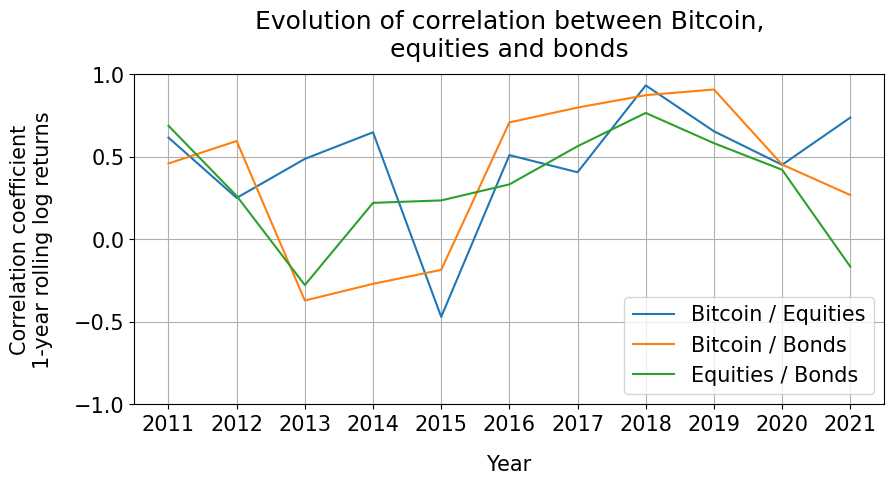

In [43]:
plt.rcParams.update(plt.rcParamsDefault)

newParams = {
    "axes.labelsize": 15,
    "font.size": 15,
    "axes.titlepad": 13,
    "axes.labelpad": 15,
    "figure.subplot.bottom": 0.18,
    "figure.subplot.left": 0.15,
    "figure.subplot.top": 0.84
}

plt.rcParams.update(newParams)

fig = hist.plot(ylim=(-1,1),xticks=years,figsize=(10,5),grid=True).get_figure()
title = "Evolution of correlation between Bitcoin,\nequities and bonds"

plt.title(title)

y = plt.ylabel("Correlation coefficient\n1-year rolling log returns")

fig.savefig("btc-corr-ts.png")

# Backtest

Add columns for all portfolio combinations

In [43]:
backtest_df = combined_df.copy()

backtest_df.columns = ["Bitcoin", "Equities", "Bonds"]
backtest_df["10% Bitcoin / 90% Equities"] = 0.1 * backtest_df["Bitcoin"] + 0.90 * backtest_df["Equities"]
backtest_df["10% Bitcoin / 90% Bonds"] = 0.1 * backtest_df["Bitcoin"] + 0.9 * backtest_df["Bonds"]
backtest_df["80%\ Equities / 20% Bonds"] = 0.8 * backtest_df["Equities"] + 0.2 * backtest_df["Bonds"]
backtest_df["10% Bitcoin / 75% Equities / 15% Bonds"] = 0.1 * backtest_df["Bitcoin"] + 0.75 * backtest_df["Equities"] + 0.15 * backtest_df["Bonds"]

Calculate returns

In [49]:
returns_1y = backtest_df.iloc[-1] / backtest_df.iloc[-356]
returns_5y = backtest_df.iloc[-1] / backtest_df.iloc[-356*5] / 5
returns_total = backtest_df.iloc[-1] / backtest_df.iloc[1] / len(backtest_df) * 356

In [15]:
import requests

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest"
}

payload = {
    "curr_id": 38224,
    "smlID": 2505638,
    "header": "{} Historical Data",
    "st_date": "19/08/2008",
    "end_date": "19/09/2021",
    "interval_sec": "Daily",
    "sort_col": "date",
    "sort_ord": "DESC",
    "action": "historical_data"
}

url = "https://uk.investing.com/instruments/HistoricalDataAjax"

response = requests.post(url, data=payload, headers=headers)

In [16]:
import pandas as pd

pd.read_html(response.content)

[              Date   Price    Open    High     Low    Vol. Change %
 0     Sep 17, 2021  105.10  105.85  105.98  104.92   2.40M   -0.99%
 1     Sep 16, 2021  106.15  106.03  106.35  105.55   1.33M   -0.23%
 2     Sep 15, 2021  106.39  105.78  106.48  105.56   1.19M    0.61%
 3     Sep 14, 2021  105.75  106.63  106.63  105.59   1.21M   -0.59%
 4     Sep 13, 2021  106.38  106.75  106.75  105.93   2.95M    0.36%
 ...            ...     ...     ...     ...     ...     ...      ...
 3318  Aug 25, 2008   46.46   46.20   47.15   46.20  50.48K   -1.84%
 3319  Aug 22, 2008   47.33   47.45   47.65   47.16  22.26K    0.53%
 3320  Aug 21, 2008   47.08   46.20   47.18   46.20  20.52K    0.77%
 3321  Aug 20, 2008   46.72   46.80   46.80   46.36  20.36K    0.91%
 3322  Aug 19, 2008   46.30   46.73   46.73   46.22  25.41K   -0.86%
 
 [3323 rows x 7 columns],
                  0              1                  2               3  \
 0  Highest: 107.74  Lowest: 24.36  Difference: 83.38  Average: 60.38  

Calculate annualised returns